In [1]:
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import sklearn.datasets as dt
import seaborn as sns         
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

- n_components: Number of dimensions to map the points to. The default value is 2.
- dissimilarity: The default value is euclidean, which specifies Euclidean pairwise distances. The other possible value is precomputed. Using precomputed requires the computation of the pairwise distance matrix and using this matrix as an input to the fit() or fit_transform() function.

In [2]:
X = np.array([[0, 0, 0], [0, 0, 1], [1, 1, 1], [0, 1, 0], [0, 1, 1]])
mds = MDS(random_state=0)
X_transform = mds.fit_transform(X)
print(X_transform)

[[ 0.72521687  0.52943352]
 [ 0.61640884 -0.48411805]
 [-0.9113603  -0.47905115]
 [-0.2190564   0.71505714]
 [-0.21120901 -0.28132146]]


- The pairwise Manhattan distances (also called the city block distance or L1 distance) and transforms the data via MDS.

In [3]:
dist_manhattan = manhattan_distances(X)
mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
X_transform_L1 = mds.fit_transform(dist_manhattan)
print(X_transform_L1)

[[ 0.9847767   0.84738596]
 [ 0.81047787 -0.37601578]
 [-1.104849   -1.06040621]
 [-0.29311254  0.87364759]
 [-0.39729303 -0.28461157]]


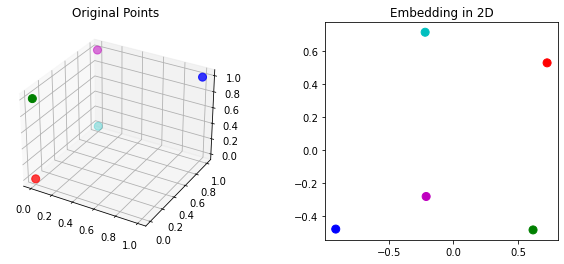

In [4]:
colors = ['r', 'g', 'b', 'c', 'm']
size = [64, 64, 64, 64, 64]
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
plt.scatter(X[:,0], X[:,1], zs=X[:,2], s=size, c=colors)
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(X_transform[:,0], X_transform[:,1], s=size, c=colors)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

# Example1 - IRIS

In [5]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
mds = MDS(2, random_state=0)
X_2d = mds.fit_transform(X_scaled)

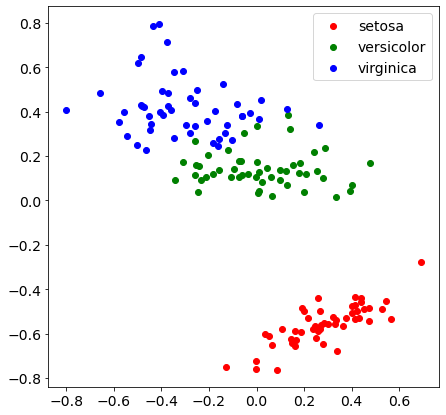

In [8]:
colors = ['red','green','blue']
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14) 
for i in np.unique(data.target):
    subset = X_2d[data.target == i]
    
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]
    plt.scatter(x, y, c=colors[i],label=data.target_names[i])
plt.legend()
plt.show()

# Example2 - molecular twins dataset

In [9]:
#Load csv file
df = pd.read_csv("early_stage_patients_multiomic_dataset.csv")
df = df.dropna()

In [10]:
# key_column: "Biobank_Number" (GI-##-### format)
clinical_prefixes = ["clinical_",]
protein_prefixes = ["plasma_protein_", "tissue_protein_", "plasma_lipid_",]
pathology_prefixes = ["pathology",]
genomics_prefixes = ["CNV_", "freebayes_SNV_", "pindel_INDEL_",]
transcriptomic_prefixes = ["AF4_", "rna_expr_",]
categorical_labels = ["label_deceased", "label_recurred",]
omics_feature_prefixes = ["clinical_", "plasma_protein_", "tissue_protein_", "plasma_lipid_", "pathology", "CNV_", "freebayes_SNV_", "pindel_INDEL_", "AF4_", "rna_expr_", "label_deceased"]

In [11]:
def subset_df_by_prefixes(df, prefixes):
    column_list = []
    for prefix in prefixes:
        column_list += df.columns[df.columns.str.startswith(prefix)].tolist()
    return df[column_list]

In [12]:
select_df = subset_df_by_prefixes(df, omics_feature_prefixes)
X = np.array(select_df)

In [13]:
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

### Multidimensional Scaling
- The multidimensional scaling method follows the sample pattern as other scikit-learn methods, we instantiate, fit and then apply or transform.

- Run multidimensional scaling on our subset of features () and project to only 2 features ().

In [19]:
# transform to 2D matric
mds = MDS(n_components=2, n_init = 20,max_iter = 1000,random_state = 73073)
X_2d = mds.fit_transform(X)

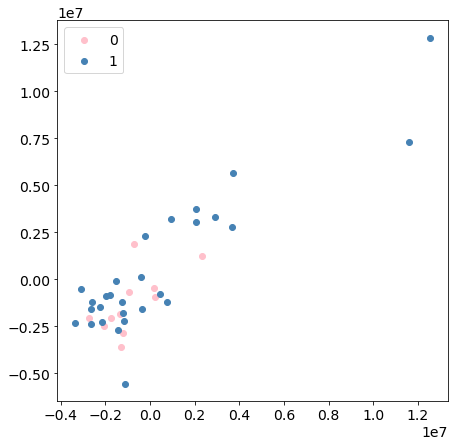

In [20]:
# Draw a 2D distance with different label
colors = ['pink', 'steelblue']
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14) 
for i in np.unique(select_df['label_deceased']):
    subset = X_2d[select_df['label_deceased'] == i]
    
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]
    plt.scatter(x, y, c=colors[i], label=list(set(select_df['label_deceased']))[i])
plt.legend()
plt.show()

### Evaluation

In [21]:
## sklearn Stress
print("sklearn stress :")
print(mds.stress_)
print("")

sklearn stress :
18463378085411.547



- Calculate the original and projected pairwise distances between all the samples

- Cross plot the original vs the projects pairwise distances

- Plot the distribution of the ratio between projects / original pariwise distances

In [22]:
dists = euclidean_distances(select_df, squared=False).ravel()
nonzero = dists != 0   # select only non-identical samples pairs
dists = dists[nonzero]
projected_dists = euclidean_distances(X_2d, squared=False).ravel()[nonzero]

Distance Ratio, mean: 0.97, standard deviation 0.09.


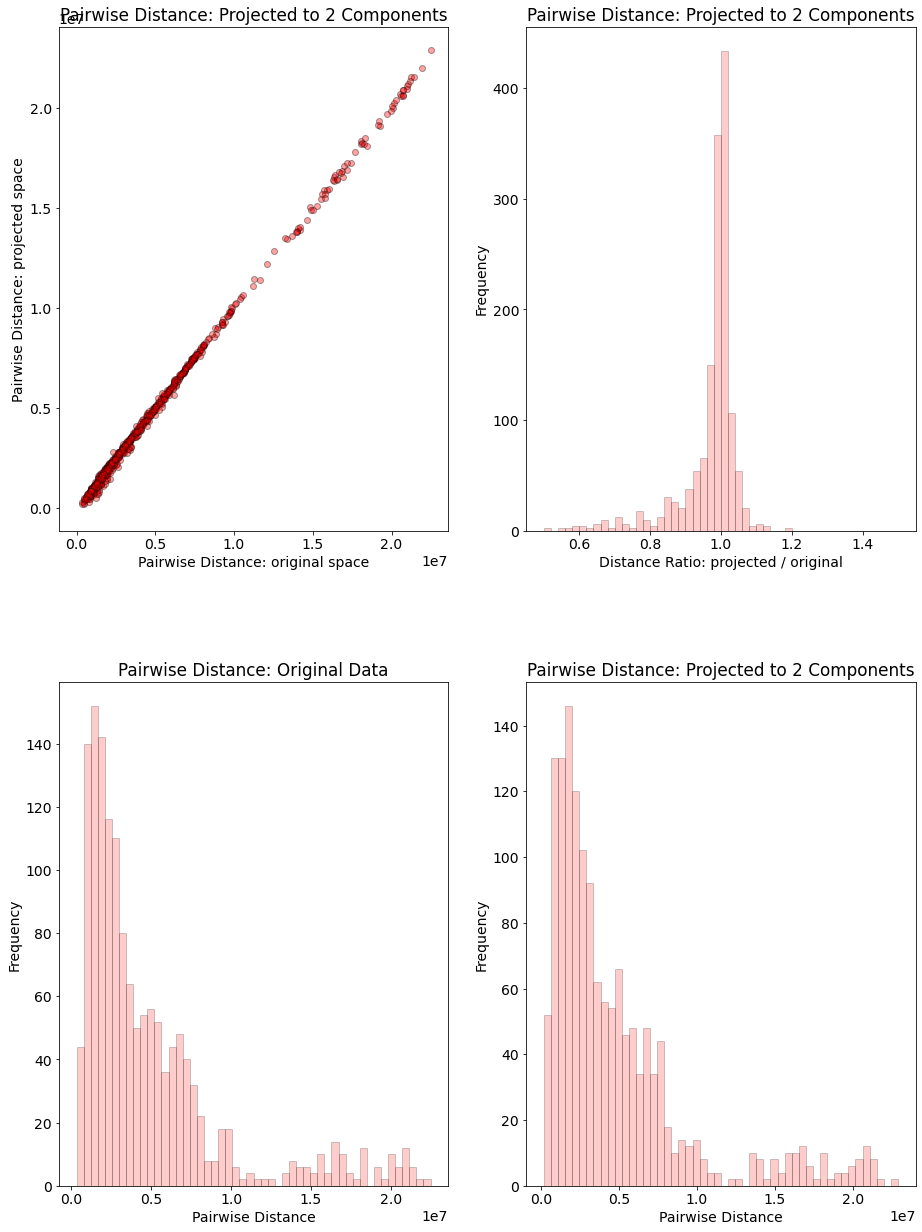

In [23]:
plt.subplot(221)
plt.scatter(dists,projected_dists,c='red',alpha=0.2,edgecolor = 'black')
plt.arrow(0,0,200,200,width=0.02,color='black',head_length=0.0,head_width=0.0)
#plt.xlim(0,15); plt.ylim(0,15)
plt.xlabel("Pairwise Distance: original space")
plt.ylabel("Pairwise Distance: projected space")
plt.title("Pairwise Distance: Projected to %d Components" % 2)

rates = projected_dists / dists
print("Distance Ratio, mean: %0.2f, standard deviation %0.2f." % (np.mean(rates), np.std(rates)))

plt.subplot(222)
plt.hist(rates, bins=50, range=(0.5, 1.5),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Distance Ratio: projected / original")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % 2)

plt.subplot(223)
plt.hist(dists, bins=50, color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Original Data")

plt.subplot(224)
plt.hist(projected_dists, bins=50,color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % 2)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=2.3, wspace=0.2, hspace=0.3)
plt.show()